# Tutorial 5: PCA

In [2]:
from importlib import reload
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import sys
import os
from sklearn.decomposition import PCA

In [3]:
FDA_DIR = os.path.join(os.getcwd(), os.pardir, r'PycharmProjects/Financial-Data-Analytics')
DATA_DIR = rf'{FDA_DIR}/Datasets'

def read_file(filename, dir=None, static=False, **kwargs):
    if dir is None:
        dir = DATA_DIR
        
    path = os.path.join(dir, filename)
    extension = filename.rsplit('.', 1)[-1]

    if extension == 'csv':
        return pd.read_csv(path, **kwargs)
    elif extension in ['parq', 'parquet']:
        return pd.read_parquet(path, **kwargs)
    elif extension == 'json':
        with open(path, 'r') as file:
            return json.load(file)
    elif extension == 'xlsx':
        return pd.read_excel(path, **kwargs)
    else:
        raise NotImplementedError

## 1. Introduction

Principal Component Analysis is a traditional multivariate statistical technique for dimension or variable reduction. 

It aims to find linear combinations of original variables such that the information in the original data is preserved.

### 1.1 Objective

The principal components are those uncorrelated linear combinations $y_1, \cdots, y_p$ whose variances are as large as possible.
 
Remark: $\mathbf{y}$ is often referred to as the transformed data matrix of $\mathbf x$, where $\mathbf x$ is projected onto the new set of principal components (eigenvectors)

### 1.2 Setting

Let the random vector $\mathbf x = (x_1, \cdots, x_p)^\top$ have the covariance matrix $\mathbf \Sigma$ with eigenvalues $\lambda_1 \geq \lambda_2 \geq \cdots \geq 0$. Consider the linear combinations
\begin{equation*}
	\mathbf y := \left(\begin{array}{c}
		y_1	\\	\vdots	\\	y_p
	\end{array}\right) = \left(\begin{array}{c}
		\mathbf a_1^\top \mathbf x \\ \vdots \\ \mathbf a_p^\top \mathbf x
	\end{array}\right) = \mathbf A \mathbf x \, .
\end{equation*}
Then, for $i,j=1,2,\cdots,p$, we have
\begin{align*}
	{\rm Var}(y_i) &= {\rm Var}(\mathbf a_i^\top \mathbf x) = \mathbf a_i^\top \mathbf \Sigma \mathbf a_i \, , \\
	{\rm Cov}(y_i, y_j) &= {\rm Cov}(\mathbf a_i^\top \mathbf x, \mathbf a_j^\top \mathbf x) = \mathbf a_i^\top \mathbf \Sigma \mathbf a_j \, .
\end{align*}

<u>Thinking</u>

But why do we need to maximize the variance and what can this achieve? Why maximized variance helps preserve the information?

### 1.3 Results from Textbook

Let $\mathbf \Sigma$ be the covariance matrix associated with the random vector $\mathbf x^\top = (x_1, \cdots, x_p)^\top$. 

Let $\mathbf \Sigma$ have the normalized eigenvalue-eigenvector pairs $(\lambda_1, \mathbf e_1 ), \cdots, (\lambda_p, \mathbf e_p)$, where $\lambda_1 \geq \lambda_2 \geq \cdots \geq \lambda_p \geq 0$. 

Then the $i$-th principal component is given by
\begin{equation*}
	y_i = \mathbf e_i^\top \mathbf x = e_{i1} x_1 + e_{i2} x_2 + \cdots + e_{ip} x_p \, , \qquad i=1,2, \cdots, p \, ,
\end{equation*}
with
\begin{alignat*}{2}
	{\rm Var}(y_i) &= \mathbf e_i^\top \mathbf \Sigma \mathbf e_i = \lambda_i \, , \qquad &&i=1,2, \cdots, p \, , \\
	{\rm Cov}(y_i, y_j) &= \mathbf e_i^\top \mathbf \Sigma \mathbf e_j = 0 \, , \qquad &&i \neq j \, .
\end{alignat*}
If some $\lambda_i$'s are equal, the choices of the corresponding coefficient vectors, $\mathbf e_i$, and hence $y_i$, are not unique.

<u>Remark:</u>

$\mathbf e_i^\top\mathbf e_j = 0,\, \text{for $i\neq j$}$

Why is this true? What is the relationship between it and $Cov(y_i, y_j)=0$? Try to argue and prove yourself.

\
The above process is actually <b>spectral decomposition</b>:

 
Given a square and symmetric matrix A, then it can be decomposed into $A = QDQ^{\top}$, 

$Q$ is the matrix where each column is an eigenvector of $A$ ($Q$ is an orthogonal matrix since $A$ is symmetric), 

$D$ is a diagonal matrix where the diagonal entries are the eigenvalues of $A$.

## 2. Application

### 2.1 Approximation of Portfolio V@R

We need the standard deviation of the loss in a portfolio to compute the $V@R$ of that portfolio. 

Let the change in the portfolio value be $\Delta P=w^\top x=w_1x_1+ \ldots + w_p x_p$ 

and we can approximate $\Delta P$ by using the first $m$ PCs of $x$ as follows (with $p >> m$):

\begin{align*} 
	\Delta P  &= w^\top x \approx w_1(h_{11}y_1+ \ldots +h_{1m}y_m + \epsilon_1)+ \ldots + w_p(h_{p1}y_1+ \ldots +h_{pm}y_m + \epsilon_p) &\\
	&= (w_1h_{11}+ \ldots + w_p h_{p1})y_1 +\ldots + (w_1 h_{1m} + \ldots +w_ph_{pm})y_m + (w_1 \epsilon_{1} + \ldots + w_p \epsilon_{p})\\
	&=: \delta_1 y_1+\ldots + \delta_m y_m + \epsilon, &
\end{align*}

where $\delta_k = \sum_{i=1}^p w_i h_{ik}$, for $k=1,2,\ldots,m$ and $\epsilon = \sum_{i=1}^p w_i \epsilon_i$ (idiosyncratic risk not captured by factors). 

The $N$-day 99\% $V@R$ of $\Delta P$ is $z_{0.99}\sqrt{N Var (\Delta P)}$, we can just use the first $m$ PCs to approximate the variance of $\Delta P$,

$$Var(\Delta P) \approx \delta_1^2 Var(y_1)+ \cdots + \delta_m^2 Var(y_m)=\delta_1^2 \lambda_1+ \cdots +\delta_m^2 \lambda_m.$$

This expression is much simpler due to the fact that all PCs are orthogonal and maintain a large portion of the variance contained in $x$.

Note: If the unexplained variance $\epsilon$ is in fact large, then we can assume independence of $\epsilon_i$.

### 2.2 Implementation: Stock Trends and Investment

In fact, in finance, one may also employ PCA for dimensionality reduction and find stocks with favorable trends to invest in. 

Specifically, we might be able to figure out the trend of the current market and build a winning portfolio.

#### 2.2.1 Dataset

Below we have the normalized returns of the S&P 500 components from 2020-01-01 to 2020-06-30.

The normalization is done as dividing the raw returns by its rolling 65-day volatility.

In [20]:
rets_norm = read_file('rets_norm_covid.parquet')

#### 2.2.2 PCA Eigenvalue and Eigenvectors

In [22]:
n_components = 10
fit_data = rets_norm.clip(-5, 5).fillna(0)

pca_mod = PCA(n_components=n_components)
pca_mod.fit(fit_data)

PCA(n_components=10)

In [23]:
eig_vec = pd.DataFrame(pca_mod.components_, columns=fit_data.columns, index=range(1, n_components + 1))
eig_vec = eig_vec.rename_axis(index='PC').rename_axis(columns='sec')
eig_val = pd.Series(pca_mod.explained_variance_ratio_, index=range(1, n_components + 1))

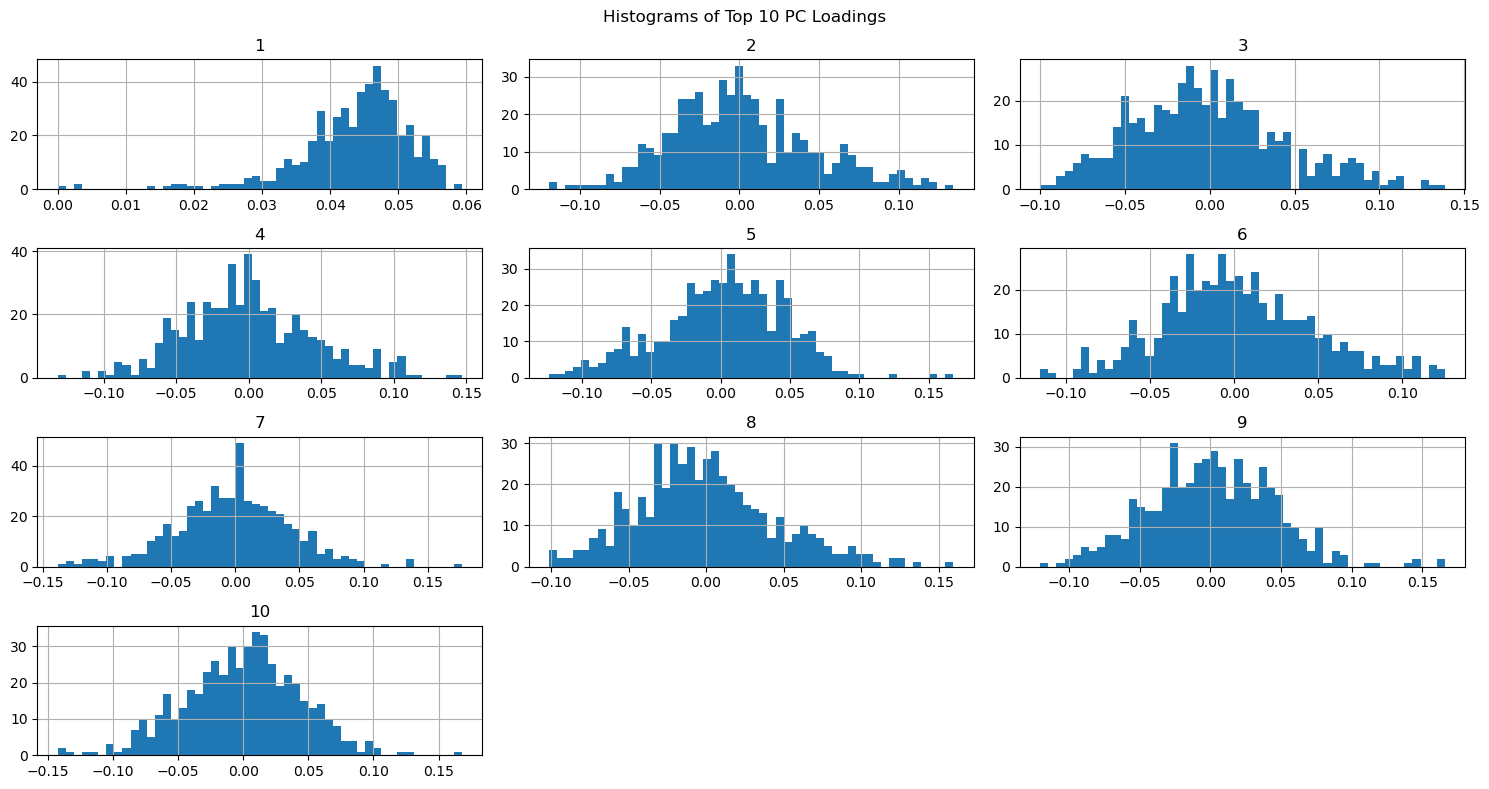

In [24]:
eig_vec.T.hist(layout=(4, 3), figsize=(15, 8), bins=50);
plt.suptitle(f'Histograms of Top {n_components} PC Loadings');
plt.tight_layout()
plt.show()

It is well known that PC1 is the "market", which means to long all stocks.

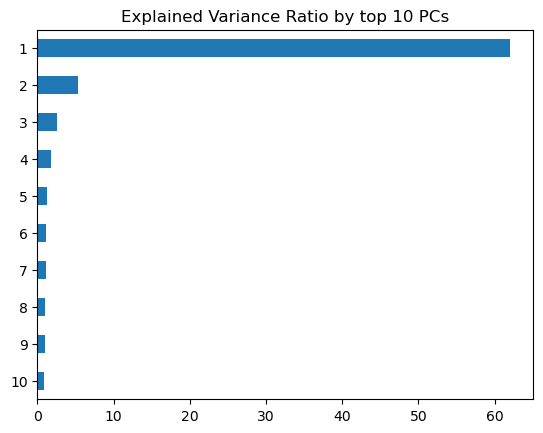

In [26]:
(eig_val * 100).plot.barh(title=f'Explained Variance Ratio by top {n_components} PCs')
plt.gca().invert_yaxis()
plt.show()

Market has $> 60 \%$ variance while PC2 is already $<10 \%$.

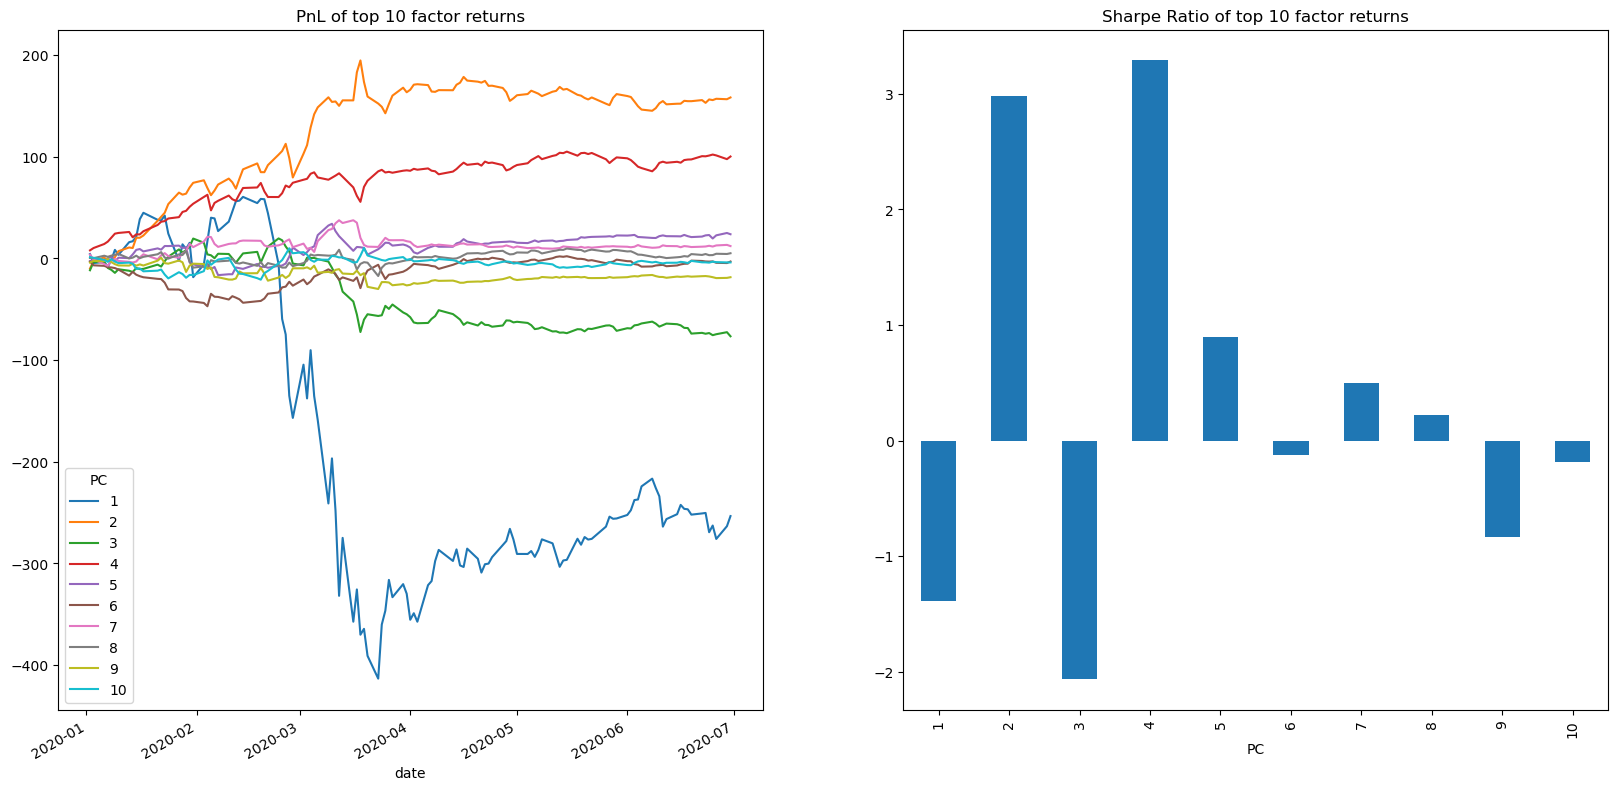

In [28]:
factor_ret = fit_data @ eig_vec.T
factor_sr = factor_ret.mean() / factor_ret.std() * np.sqrt(260)

fig, ax = plt.subplots(1, 2, figsize=(20, 10));

factor_ret.cumsum().plot(ax=ax[0], title=f'PnL of top {n_components} factor returns');
factor_sr.plot.bar(title=f'Sharpe Ratio of top {n_components} factor returns', ax=ax[1]);

#### 2.2.3 Sector Analysis on PCA factors

We can classify stocks into different sectors according to GICS.

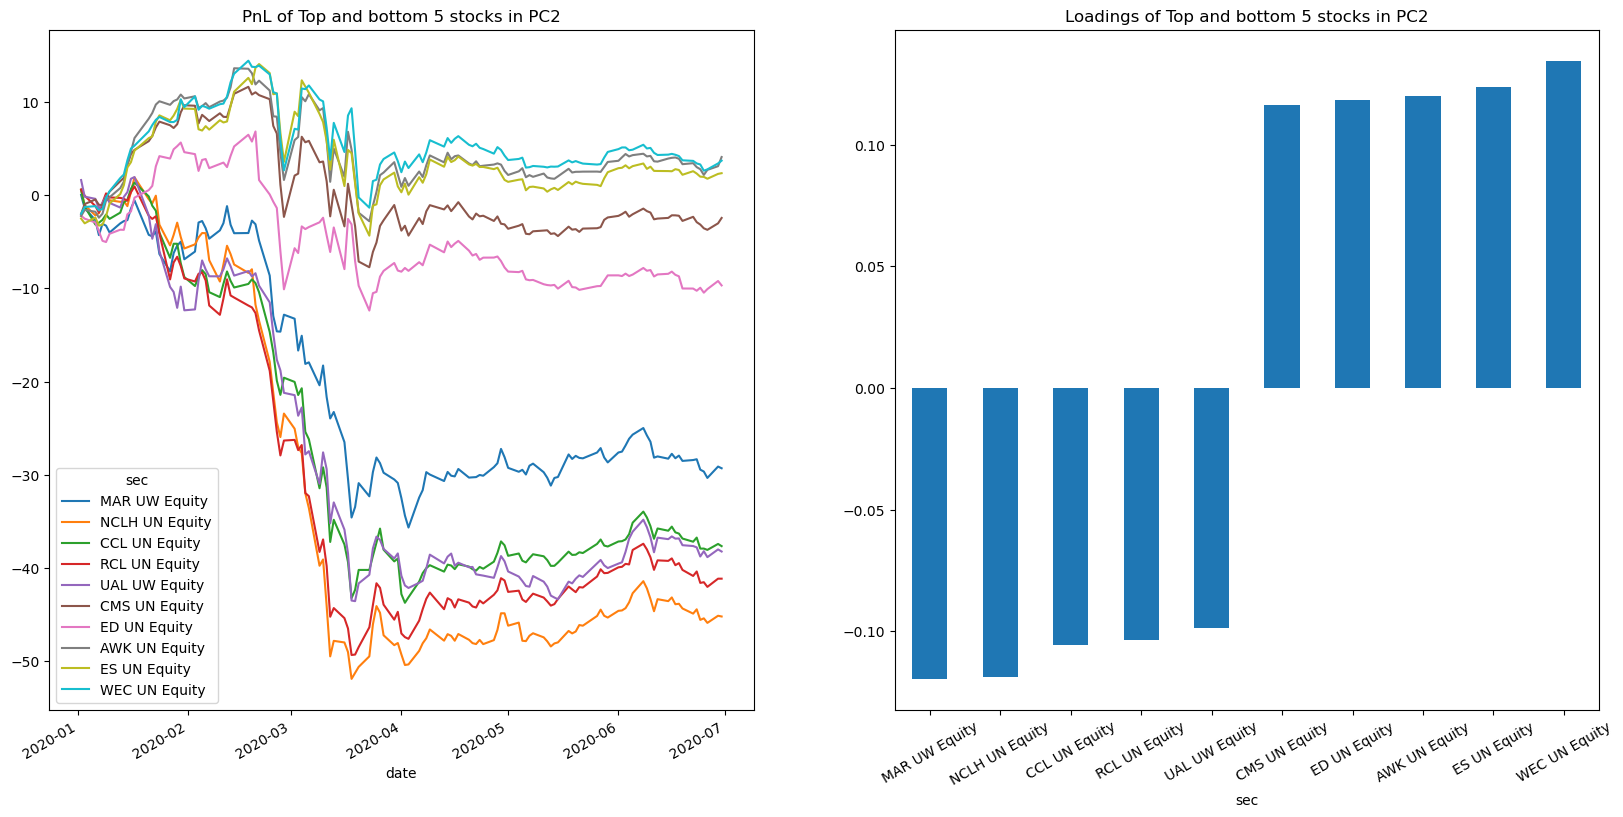

In [31]:
pc = 2
top_bottom_n = 5
title=f"Loadings of Top and bottom {top_bottom_n} stocks in PC{pc}"
pc_stocks = eig_vec.loc[pc].sort_values().iloc[np.r_[0:top_bottom_n, -top_bottom_n:0]]

fig, ax = plt.subplots(1, 2, figsize=(20, 10));

pc_stocks.plot.bar(title=title, ax=ax[1]);
ax[1].set_xticklabels(labels=pc_stocks.index, rotation=30);

rets_norm.loc[:, pc_stocks.index].cumsum().plot(ax=ax[0], title=f"PnL of Top and bottom {top_bottom_n} stocks in PC{pc}");

<u>Long</u>

Energy: WEC, ES, ED, CMS

Utilities: AWK

<u>Short</u>

Consumer Discretionary: 

1. Cruise: NCLH, RCL, CCL
2. Hotel: MAR
3. Airline: UAL

-> Undoubtedly, the travel industry is much impacted. 

While on the long side, it is well known that many traders speculate on the spread between energy and cruise & airline.

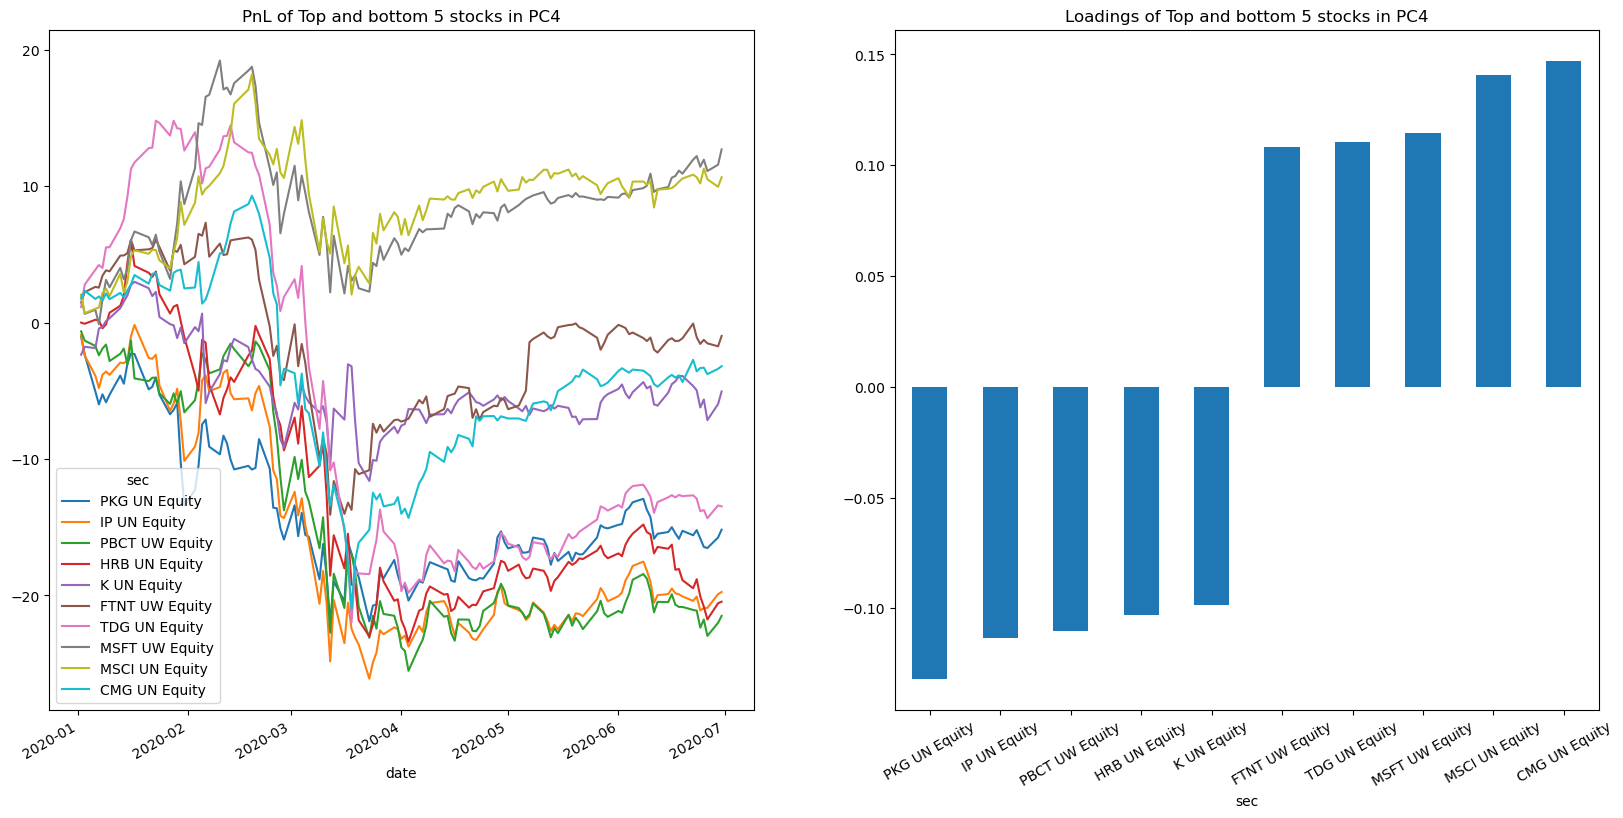

In [33]:
pc = 4
top_bottom_n = 5
title=f"Loadings of Top and bottom {top_bottom_n} stocks in PC{pc}"
pc_stocks = eig_vec.loc[pc].sort_values().iloc[np.r_[0:top_bottom_n, -top_bottom_n:0]]

fig, ax = plt.subplots(1, 2, figsize=(20, 10));

pc_stocks.plot.bar(title=title, ax=ax[1]);
ax[1].set_xticklabels(labels=pc_stocks.index, rotation=30);

rets_norm.loc[:, pc_stocks.index].cumsum().plot(ax=ax[0], title=f"PnL of Top and bottom {top_bottom_n} stocks in PC{pc}");

Similarly, we see packaging sectors are affected, maybe because the transportation of goods are suspended.

Meanwhile, IT firms like MSFT benefit from work from home policy. 

Chipotle also gained because of food delivery demands.

### 2.3 <b>Rolling PCA (Project)</b>

If you want to choose PCA as your project topic. You will be analyzing and describing the <b>dynamic</b> market structure.

So, here are a few questions you need to think about.

1. Should you normalize / whiten your data before PCA? If so, what is the <i>intrinsic</i> meaning of the transformed data?

2. How to handle missing data in PCA? Is filling 0 always the best?

3. How to make sure there are no sign flipping of the same PC? (e.g. PC2 in the last period $v_2$ "changes to" $-v_2$ in the current period)

4. How to make sure there are no switching of PCs? (e.g. PC2 in the last period "becomes" PC3 in the current period)

\
For sure, there are answers to the above, but I will leave the details for you to "fill in the blanks".

Also, it counts on you to verify that your rolling PCA result is robust to the above issues.

Finally, you will get a bonus point if you can implement all the above in a class.

## 3. Exercise

Find the eigenvectors and eigenvalues of:
\begin{equation*}
    \mathbf A = \left(\begin{array}{ccc}
        2	&	1	&	3	\\
        1	&	2	&	3	\\
        3	&	3	&	20
    \end{array}\right) \, .
\end{equation*}

We first find the characteristic equation of

\begin{align*}
    | \mathbf A - \lambda \mathbf I_3| &= \left|\begin{array}{ccc}
        2 - \lambda	&	1	&	3	\\
        1	&	2 - \lambda	&	3	\\
        3	&	3	&	20 - \lambda
    \end{array}\right| \\
    &= (2 - \lambda) 
    \left|\begin{array}{cc}
        2 - \lambda	&	3	\\
        3	&	20 - \lambda
    \end{array}\right| + (1) \cdot (-1)
    \left|\begin{array}{cc}
        1	&	3	\\
        3	&	20 - \lambda
    \end{array}\right| + (3) 
    \left|\begin{array}{cc}
        1	&	2 - \lambda	\\
        3	&	3
    \end{array}\right| \\
    &= (2 - \lambda)(40 - 22 \lambda + \lambda^2 - 9) - 1(20 - \lambda - 9) + 3(3 - 6 + 3 \lambda) \\
    &= -\lambda^3 + 24 \lambda^2 - 65 \lambda + 42 = (\lambda-1)(\lambda-2)(-\lambda+21) \, .
\end{align*}

Therefore, the eigenvalues are 1, 2, and 21. The eigenvectors are the solutions to the equation:

\begin{equation*} 
    \mathbf A \mathbf \alpha = \lambda \mathbf \alpha \qquad \Leftrightarrow \qquad (\mathbf A - \lambda \mathbf I)\mathbf \alpha = \mathbf 0 \, .
\end{equation*}

Therefore, for $\lambda=1$, we have

\begin{equation*}
    \left(\begin{array}{ccc|c}
        2 - 1	&	1	&	3	&	0	\\
        1	&	2 - 1	&	3	&	0	\\
        3	&	3	&	20 - 1	&	0
    \end{array}\right) \sim \left(\begin{array}{ccc|c}
        1	&	1	&	3	&	0	\\
        0	&	0	&	0	&	0	\\
        0	&	0	&	10	&	0
    \end{array}\right) \, .
\end{equation*}
Therefore, the solution for $\lambda=1$ is $(\alpha_{11}, -\alpha_{11}, 0)^\top$, 

and normalizing it to obtain the corresponding eigenvector $\mathbf \alpha_1 = (\sqrt{2}/2, -\sqrt{2}/2, 0)^\top$ or $(-\sqrt{2}/2, \sqrt{2}/2, 0)^\top$. 

\
Similarly, for $\lambda=2$, we have
\begin{equation*}
    \left(\begin{array}{ccc|c}
        2 - 2	&	1	&	3	&	0	\\
        1	&	2 - 2	&	3	&	0	\\
        3	&	3	&	20 - 2	&	0
    \end{array}\right) \sim \left(\begin{array}{ccc|c}
        0	&	1	&	3	&	0	\\
        1	&	0	&	3	&	0	\\
        3	&	0	&	9	&	0
    \end{array}\right) \sim  \left(\begin{array}{ccc|c}
        0	&	1	&	3	&	0	\\
        1	&	0	&	3	&	0	\\
        0	&	0	&	0	&	0
    \end{array}\right) \, .
\end{equation*}

Therefore, the solution for $\lambda=2$ is $(-3\alpha_{23}, -3\alpha_{23}, \alpha_{23})^\top$, 

and normalizing it to obtain the corresponding eigenvector $\mathbf \alpha_2 = (3/\sqrt{19}, 3/\sqrt{19}, -1/\sqrt{19})^\top$ or $(-3/\sqrt{19}, -3/\sqrt{19}, 1/\sqrt{19})^\top$. 

\
Finally, for $\lambda=21$, we have

\begin{align*}
    \left(\begin{array}{ccc|c}
        2 - 21	&	1	&	3	&	0	\\
        1	&	2 - 21	&	3	&	0	\\
        3	&	3	&	20 - 21	&	0
    \end{array}\right) &\sim \left(\begin{array}{ccc|c}
        -19	&	1	&	3	&	0	\\
        1	&	-19	&	3	&	0	\\
        3	&	3	&	-1	&	0
    \end{array}\right) \sim  \left(\begin{array}{ccc|c}
        0	&	-360	&	60	&	0	\\
        1	&	-19	&	3	&	0	\\
        0	&	60	&	-10	&	0
    \end{array}\right) \\
    &\sim  \left(\begin{array}{ccc|c}
        0	&	-6	&	1	&	0	\\
        1	&	-1	&	0	&	0	\\
        0	&	0	&	0	&	0
    \end{array}\right)\, .
\end{align*}

Therefore, the solution for $\lambda=21$ is $(\alpha_{33}/6, \alpha_{33}/6, \alpha_{33})^\top$,

and normalizing it to obtain the corresponding eigenvector $\mathbf \alpha_3 = (\sqrt{18}/(6\sqrt{19}), \sqrt{18}/(6\sqrt{19}), \sqrt{18}/\sqrt{19})^\top$ or $(-\sqrt{18}/(6\sqrt{19}), -\sqrt{18}/(6\sqrt{19}), -\sqrt{18}/\sqrt{19})^\top$.